In [2]:
from pathlib import Path
# from numba import jit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading | Overview

In [3]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [4]:
print(f"In train_identity:\t num of columns = {len(train_identity.columns)} \t num of rows = {len(train_identity)}")
print(f"In train_tx:      \t num of columns = {len(train_tx.columns)} \t num of rows = {len(train_tx)}")
print("="*70)
print(f"In test_identity: \t num of columns = {len(test_identity.columns)} \t num of rows = {len(test_identity)}")
print(f"In test_tx:       \t num of columns = {len(test_tx.columns)} \t num of rows = {len(test_tx)}")

In train_identity:	 num of columns = 41 	 num of rows = 144233
In train_tx:      	 num of columns = 394 	 num of rows = 590540
In test_identity: 	 num of columns = 41 	 num of rows = 141907
In test_tx:       	 num of columns = 393 	 num of rows = 506691


## Quick Look on Identity DF

not all transactions have corresponding identity data

**Identity Columns:**

- TransactionID
- id_01 - id_38
- DeviceType: eg(mobile, desktop, etc..)
- DeviceInfo: eg(Windows, Samsung, etc..)

**Categorical Features - Identity:**
- DeviceType
- DeviceInfo
- id_12 - id_38: 

In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
identity_cat_cols = ['DeviceType', 'DeviceInfo'] + [f'id_{i}' for i in range(12, 38 + 1)]
identity_num_cols = [f'id_0{i}' for i in range(1, 10)] + ['id_10', 'id_11']

In [7]:
train_identity[identity_num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_01,144233.0,-10.170502,14.347949,-100.0,-10.0,-5.0,-5.0,0.0
id_02,140872.0,174716.584708,159651.816856,1.0,67992.0,125800.5,228749.0,999595.0
id_03,66324.0,0.060189,0.598231,-13.0,0.0,0.0,0.0,10.0
id_04,66324.0,-0.058938,0.701015,-28.0,0.0,0.0,0.0,0.0
id_05,136865.0,1.615585,5.249856,-72.0,0.0,0.0,1.0,52.0
id_06,136865.0,-6.698710,16.491104,-100.0,-6.0,0.0,0.0,0.0
id_07,5155.0,13.285354,11.384207,-46.0,5.0,14.0,22.0,61.0
id_08,5155.0,-38.600388,26.084899,-100.0,-48.0,-34.0,-23.0,0.0
id_09,74926.0,0.091023,0.983842,-36.0,0.0,0.0,0.0,25.0
id_10,74926.0,-0.301124,2.789446,-100.0,0.0,0.0,0.0,0.0


In [8]:
train_identity[identity_cat_cols].describe(include='all').transpose()[['count', 'unique', 'top', 'freq']]

,count,unique,top,freq
DeviceType,140810,2,desktop,85165
DeviceInfo,118666,1786,Windows,47722
id_12,144233,2,NotFound,123025
id_13,127320.0,NaN,NaN,NaN
id_14,80044.0,NaN,NaN,NaN
id_15,140985,3,Found,67728
id_16,129340,2,Found,66324
id_17,139369.0,NaN,NaN,NaN
id_18,45113.0,NaN,NaN,NaN
id_19,139318.0,NaN,NaN,NaN


In [9]:
(train_identity.isnull().sum() / len(train_identity) * 100).sort_values(ascending=False)

id_24            96.708798
id_25            96.441868
id_07            96.425922
id_08            96.425922
id_21            96.423149
id_26            96.420375
id_23            96.416215
id_27            96.416215
id_22            96.416215
id_18            68.722137
id_04            54.016071
id_03            54.016071
id_33            49.187079
id_10            48.052110
id_09            48.052110
id_30            46.222432
id_32            46.207872
id_34            46.056034
id_14            44.503685
DeviceInfo       17.726179
id_13            11.726165
id_16            10.325654
id_06             5.108401
id_05             5.108401
id_20             3.447200
id_19             3.407681
id_17             3.372321
id_31             2.739318
DeviceType        2.373243
id_02             2.330257
id_28             2.256765
id_29             2.256765
id_11             2.256765
id_38             2.251912
id_35             2.251912
id_36             2.251912
id_15             2.251912
i

### Conclusion

`id_01` is interesting column as there's no nulls and values in negative

we can remove those columns as many of them are nulls
```
id_23            96.416215
id_27            96.416215
id_22            96.416215
id_26            96.420375
id_21            96.423149
id_08            96.425922
id_07            96.425922
id_25            96.441868
id_24            96.708798
```

## Quick Look on Transactions

**isFraud** target

**Columns - Transaction:**
1. TransactionID
1. TransactionDT
1. TransactionAmt
1. ProductCD
1. card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
1. addr1 - addr2 	
1. dist1 - dist2
1. P_emaildomain
1. R_emaildomain
1. C1 - C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked
1. D1-D15: timedelta, such as days between previous transaction, etc. 
1. M1-M9: match, such as names on card and address, etc.
1. Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction:**
1. ProductCD:      Product code, the product for each transaction 
1. emaildomain
1. card1 - card6:  payment card information, such as card type, card category, issue bank, country, etc. 
1. addr1, addr2
1. P_emaildomain:  purchaser email domain
1. R_emaildomain:  recipient email domain
1. M1 - M9:        match, such as names on card and address, etc.

In [10]:
train_tx.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [11]:
tx_cat_cols = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + [f'card{i}' for i in range(1,7)] + [f'M{i}' for i in range(1,10)]
tx_num_cols = ['isFraud','TransactionDT', 'TransactionAmt', 'dist1', 'dist2'] + [f'C{i}' for i in range(1, 15)] + [f'D{i}' for i in range(1, 16)] + [f'V{i}' for i in range(1, 339+1)]

In [12]:
train_tx[tx_num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3.027058e+06,7.306528e+06,1.124662e+07,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,4.332100e+01,6.876900e+01,1.250000e+02,3.193739e+04
dist1,238269.0,1.185022e+02,3.718720e+02,0.000,3.000000e+00,8.000000e+00,2.400000e+01,1.028600e+04
dist2,37627.0,2.318554e+02,5.290535e+02,0.000,7.000000e+00,3.700000e+01,2.060000e+02,1.162300e+04
C1,590540.0,1.409246e+01,1.335690e+02,0.000,1.000000e+00,1.000000e+00,3.000000e+00,4.685000e+03
C2,590540.0,1.526973e+01,1.546689e+02,0.000,1.000000e+00,1.000000e+00,3.000000e+00,5.691000e+03
C3,590540.0,5.643987e-03,1.505356e-01,0.000,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01
C4,590540.0,4.092185e+00,6.884846e+01,0.000,0.000000e+00,0.000000e+00,0.000000e+00,2.253000e+03
C5,590540.0,5.571526e+00,2.578698e+01,0.000,0.000000e+00,0.000000e+00,1.000000e+00,3.490000e+02


In [13]:
train_tx[tx_cat_cols].describe(include='all').transpose()[['count', 'unique', 'top', 'freq']]

,count,unique,top,freq
ProductCD,590540,5,W,439670
addr1,524834.0,NaN,NaN,NaN
addr2,524834.0,NaN,NaN,NaN
P_emaildomain,496084,59,gmail.com,228355
R_emaildomain,137291,60,gmail.com,57147
card1,590540.0,NaN,NaN,NaN
card2,581607.0,NaN,NaN,NaN
card3,588975.0,NaN,NaN,NaN
card4,588963,4,visa,384767
card5,586281.0,NaN,NaN,NaN


In [14]:
(train_tx.isnull().sum() / len(train_tx) * 100).sort_values(ascending=False)

dist2             93.628374
D7                93.409930
D13               89.509263
D14               89.469469
D12               89.041047
D6                87.606767
D9                87.312290
D8                87.312290
V153              86.123717
V149              86.123717
V141              86.123717
V146              86.123717
V154              86.123717
V162              86.123717
V142              86.123717
V158              86.123717
V161              86.123717
V157              86.123717
V138              86.123717
V139              86.123717
V148              86.123717
V140              86.123717
V155              86.123717
V156              86.123717
V147              86.123717
V163              86.123717
V143              86.122701
V145              86.122701
V144              86.122701
V165              86.122701
V164              86.122701
V152              86.122701
V150              86.122701
V151              86.122701
V160              86.122701
V159              86

In [15]:
train_tx['isFraud'].value_counts() / len(train_tx) * 100

isFraud
0    96.500999
1     3.499001
Name: count, dtype: float64

Text(0.5, 1.0, 'Percentage of Is Fraud in train')

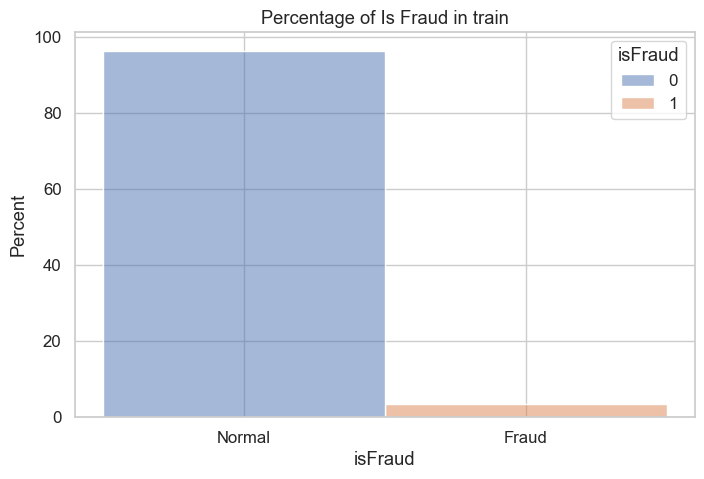

In [16]:
sns.histplot(train_tx, x='isFraud', bins=2, stat="percent",  discrete=True, hue='isFraud')
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.title("Percentage of Is Fraud in train")

### Conclusion

- high skew in target there's *96.5* normal transactions & *3.5* fraud transactions

- there's many columns have very low variation or dominant by class

- null also problem in this df

# Main EDA

In [17]:
train = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

In [18]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.


In [19]:
train_ = train.copy()

### id columns visualization

In [20]:
# train['id_01'].value_counts().sort_values(ascending=False)/ len(train)

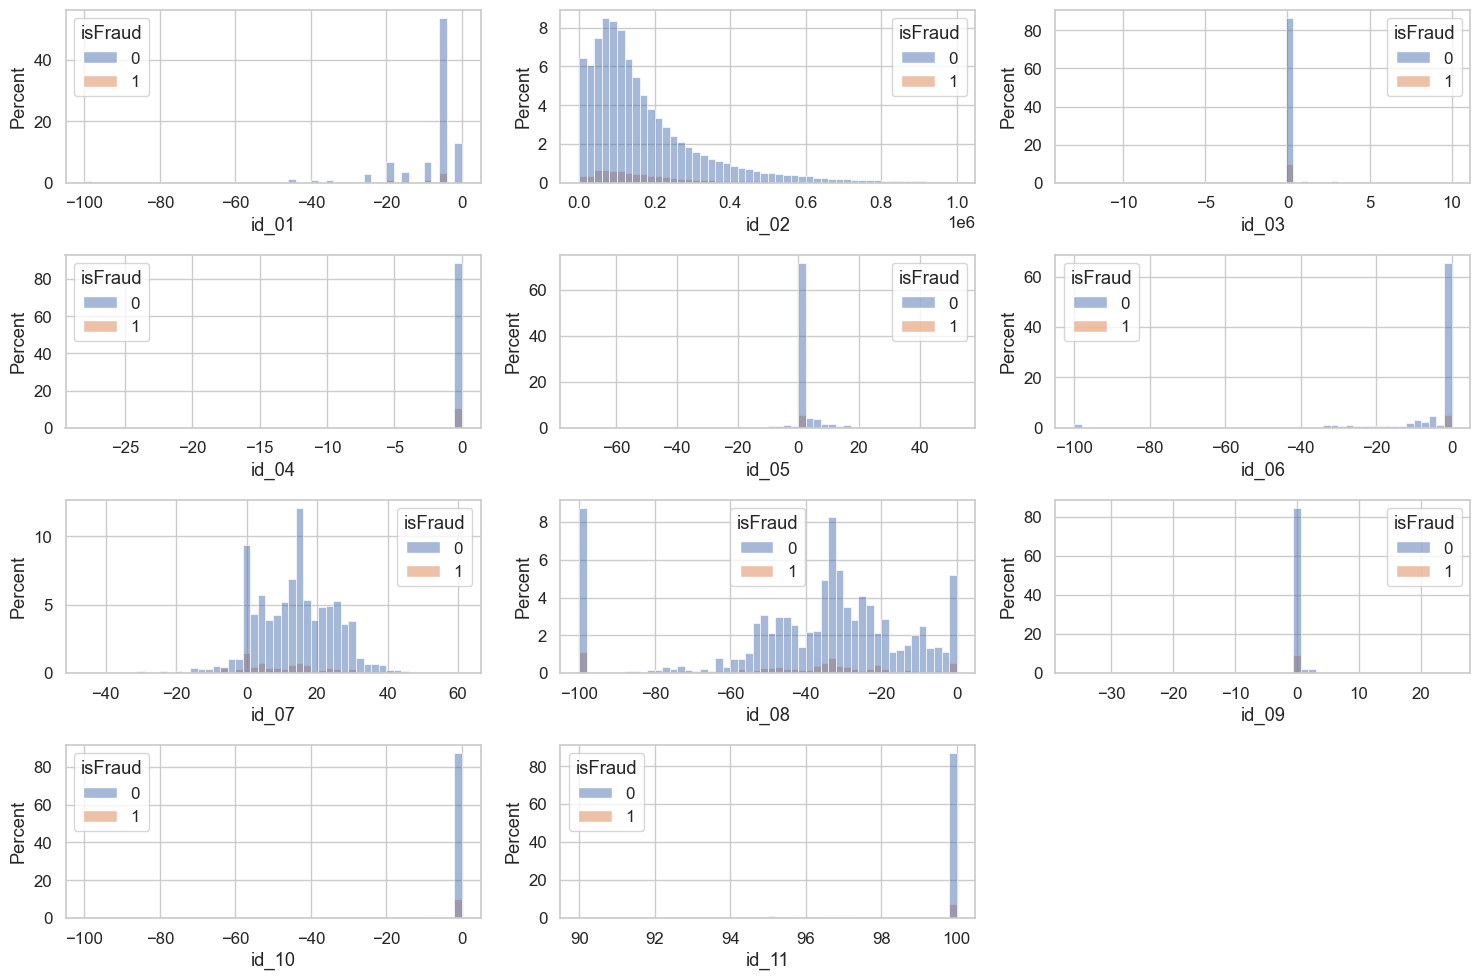

In [21]:
plt.figure(figsize=(15, 10))
for i in range(1, 12):
    plt.subplot(4, 3, i)
    sns.histplot(train, x=f'id_{i:02d}', stat='percent', bins=50, hue='isFraud')
plt.tight_layout()
plt.show()

**most of numerical ids is nulls**
- id_01: 77 unique values 
- id_02: very large values with very large difference between them may be scaled & need to be normalized
---
- id_03, id_04: 88.77% missing values -- with (24, 15) unique values and most of rest are 0
- id_05, id_06: 76.82% missing values  -- with 15.5% of rest equal 0
- id_07: 99.13% missing values
- id_08: 99.13% missing values Also I suspect there's value filling by -100 where it somewhat left skew to zero
- id_09, id_10: 87.31% missing values -- with aprroximate 11% of rest equal 0
- id_11: 76.13% missing values -- with 22.5% of rest equal 100

In [22]:
train_[identity_cat_cols] = train_[identity_cat_cols].fillna('null').astype('str')

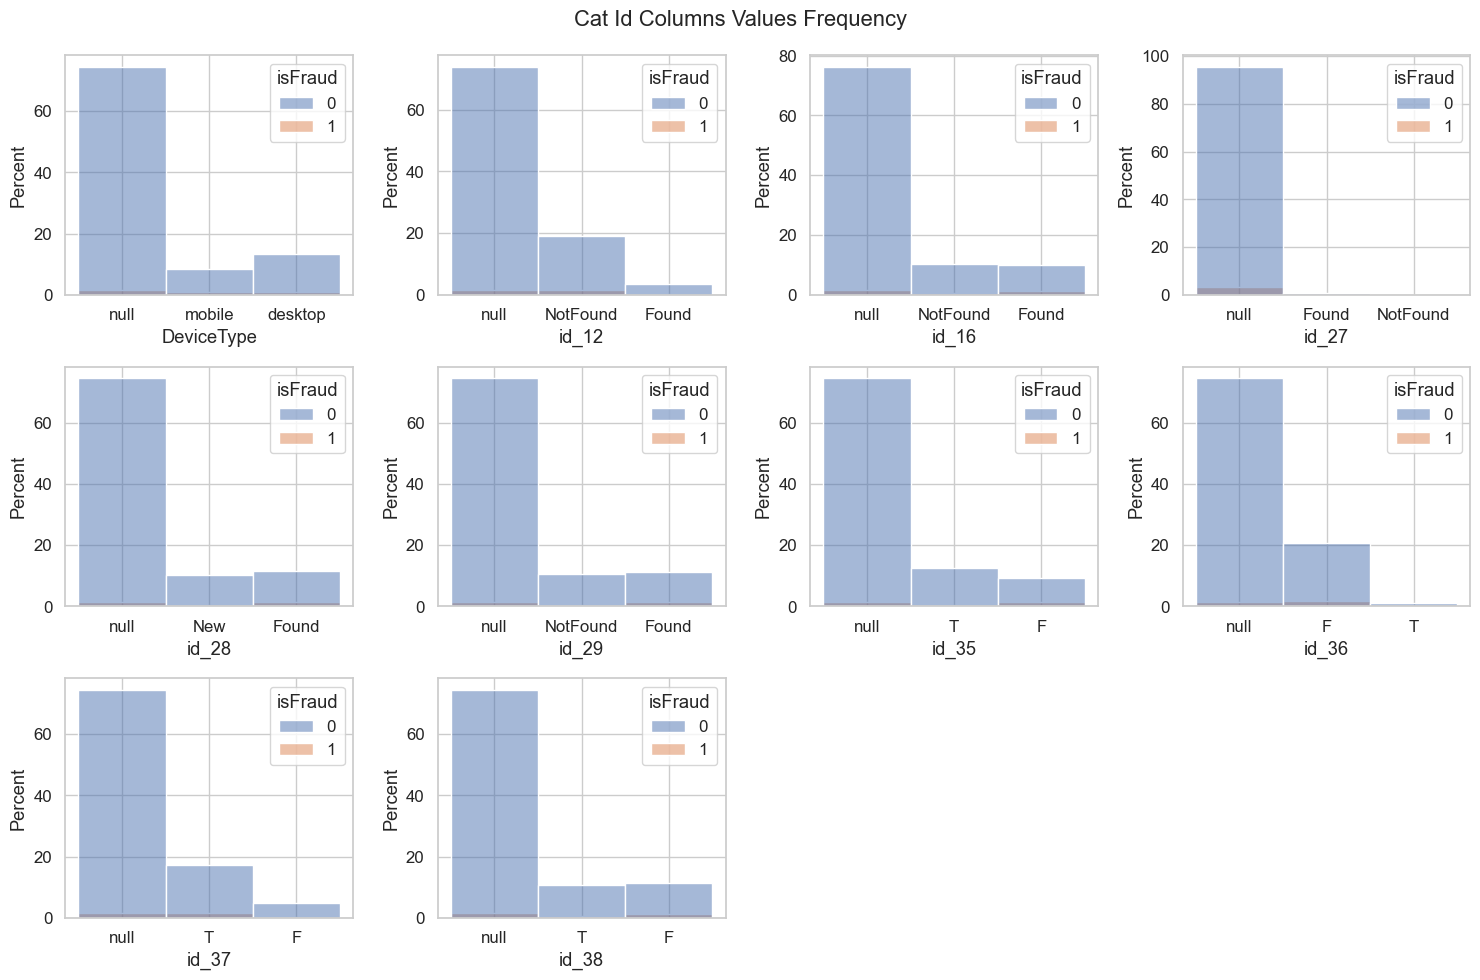

In [23]:
plt.figure(figsize=(15, 10))

idx = 1
for col in identity_cat_cols:
    if len(train_[col].value_counts()) > 3:  continue
    
    ax = plt.subplot(3, 4, idx)
    sns.histplot(
        train_, 
        x=col, 
        stat='percent', 
        discrete=True, 
        hue='isFraud',
    )
    
    idx += 1
    
    
plt.suptitle("Cat Id Columns Values Frequency")
plt.tight_layout()
plt.show()

- [ ] TODO: visualize later columns

In [24]:
len(identity_cat_cols)

29